In [1]:
import numpy as np
import epde.interface.interface as epde_alg
import torch
from epde.interface.prepared_tokens import CustomTokens, CacheStoredTokens, ExternalDerivativesTokens, TrigonometricTokens
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re

import matplotlib as mpl
mpl.rc('text', usetex=False)

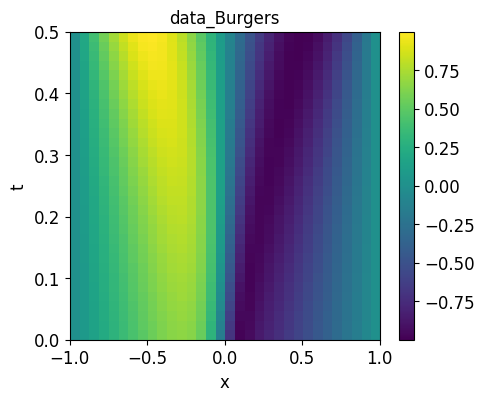

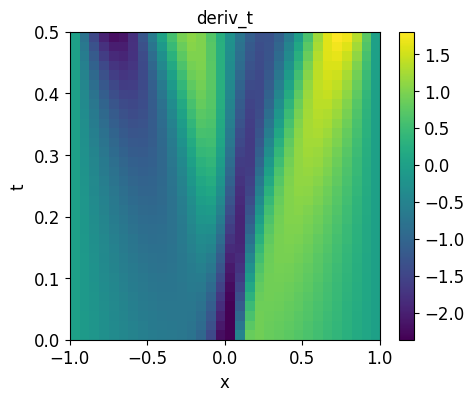

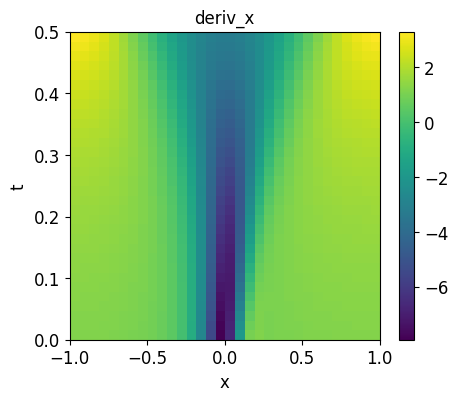

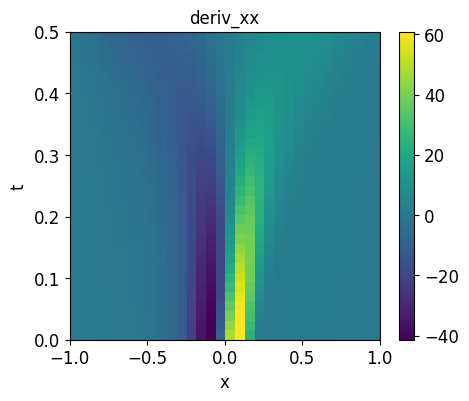

In [4]:
x = np.linspace(-1, 1, 32)  
t = np.linspace(0, 0.5, 32)
data = np.load('data_Burgers_noise0.npy')  
deriv_x = np.load('Burgers_Gradient_x_noise0.npy')
deriv_xx = np.load('Burgers_Gradient_xx_noise0.npy')
deriv_t = np.load('Burgers_gradient_t_noise0.npy')

boundary = 5
dimensionality = data.ndim - 1   
grids = np.meshgrid(t, x, indexing = 'ij')    

plt.figure(figsize=(5, 4))
plt.imshow(data, aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('data_Burgers')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(deriv_t, aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('deriv_t')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(deriv_x, aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('deriv_x')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5, 4))
plt.imshow(deriv_xx, aspect='auto', extent=[np.min(x), np.max(x),np.min(t), np.max(t)], cmap='viridis')
plt.colorbar()
plt.title('deriv_xx')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [5]:
multiobjective_mode = True
epde_search_obj = epde_alg.EpdeSearch(multiobjective_mode=multiobjective_mode, use_solver = False, 
                                        dimensionality = dimensionality, boundary = 5,
                                        coordinate_tensors = grids)

epde_search_obj.set_preprocessor(default_preprocessor_type='poly', # use_smoothing = True
                                     preprocessor_kwargs={'use_smoothing' : False})    
popsize = 7
if multiobjective_mode:
    epde_search_obj.set_moeadd_params(population_size = popsize, 
                                        training_epochs=80)
else:
    epde_search_obj.set_singleobjective_params(population_size = popsize, 
                                                training_epochs=80)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x0000015D405A14C0>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x0000015D405A14C0>


In [6]:
print(grids[0].shape)
print(grids[1].shape)
print(deriv_x.shape)
print(data.shape)

(32, 32)
(32, 32)
(32, 32)
(32, 32)


In [7]:
#Burgers
factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.5, 0.5]}

derivs = np.stack((deriv_t.reshape(-1),
                   deriv_x.reshape(-1),
                   deriv_xx.reshape(-1)), axis=1)


print('data.shape =', torch.tensor(data).shape)
print('derivs.shape = ', torch.tensor(derivs).shape)
opt_val = 1e-8
bounds = (1e-8, 1e-2) if multiobjective_mode else (opt_val, opt_val) 

results = []

for i in range(10):
    epde_search_obj.fit(data=data, variable_names=['u',], max_deriv_order=(1, 2), derivs = [derivs,],
                        equation_terms_max_number=8, data_fun_pow=2, 
                        #additional_tokens=[custom_grid_tokens],
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=bounds)
    text_eq = epde_search_obj.equations(only_print=False, only_str=True, num=1)
    results.extend(text_eq)  
results = list(itertools.chain.from_iterable(results))
print(results)


data.shape = torch.Size([32, 32])
derivs.shape =  torch.Size([1024, 3])
Deriv orders after definition [[None], [0], [1], [1, 1]]
initial_shape (32, 32) derivs_tensor.shape (1024, 3)
self.tokens is ['u', 'du/dx0', 'du/dx1', 'd^2u/dx1^2']
Here, derivs order is {'u': [None], 'du/dx0': [0], 'du/dx1': [1], 'd^2u/dx1^2': [1, 1]}
The cardinality of defined token pool is [4]
Among them, the pool contains [4]
Creating new equation, sparsity value [4.26100864e-07]
New solution accepted, confirmed 1/7 solutions.
Creating new equation, sparsity value [6.53248256e-06]
New solution accepted, confirmed 2/7 solutions.
Creating new equation, sparsity value [4.63683574e-06]
New solution accepted, confirmed 3/7 solutions.
Creating new equation, sparsity value [4.73466986e-06]
New solution accepted, confirmed 4/7 solutions.
Creating new equation, sparsity value [8.37595067e-08]
New solution accepted, confirmed 5/7 solutions.
Creating new equation, sparsity value [2.1273513e-05]
New solution accepted, conf

In [8]:
results


["0.0 * d^2u/dx1^2{power: 1.0} + -0.6720702322616564 * u{power: 1.0} * du/dx1{power: 1.0} + 0.0 * du/dx1{power: 1.0} * du/dx0{power: 1.0} + -0.012421245391037325 * d^2u/dx1^2{power: 1.0} * du/dx0{power: 1.0} + -0.5531857833997597 * u{power: 1.0} + -0.44053347236924273 * u{power: 2.0} + 0.12766011403436395 * du/dx1{power: 1.0} + 0.029246833853716656 = du/dx0{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 8}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.5, 0.5]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.002979828463677308}}",
 "0.0 * du/dx1{power: 2.0} + 0.26966532828401574 * u{power: 1.0} + 0.0332331530139879 * d^2u/dx1^2{power: 1.0} * u{power: 1.0} + -0.9313070263861486 * du/dx0{power: 1.0} + 0.06186909607042882 * d^2u/dx1^2{power: 1.0} + 0.06528327681500365 * u{power: 2.0} + 0.034692677856627475 * du/dx0{power: 1.0} * du/dx1{power: 1.0} + -0.034767061783435464 = du/dx1{power: 1.0} * u{power: 1.0}\n{'terms_number

In [9]:
#переносим все в левую часть и сохраняем в таком виде
def transform_equation(equation):
    left_side, right_side = equation.split('=')
    left_side = left_side.strip()
    right_side = right_side.strip().split('\n')[0]  
    new_term = f"-1.0 * {right_side}"
    left_side_parts = left_side.split('+')
    left_side_parts = [part.strip() for part in left_side_parts]
    last_term = left_side_parts[-1]
    
    left_side_parts.insert(-1, new_term) 
    
    final_left_side = ' + '.join(left_side_parts)
    final_equation = f"{final_left_side} = 0.0\n{equation.split('\n', 1)[-1]}"
    
    return final_equation

transformed_results = [transform_equation(eq) for eq in results]

for transformed in transformed_results:
    print(transformed)

0.0 * d^2u/dx1^2{power: 1.0} + -0.6720702322616564 * u{power: 1.0} * du/dx1{power: 1.0} + 0.0 * du/dx1{power: 1.0} * du/dx0{power: 1.0} + -0.012421245391037325 * d^2u/dx1^2{power: 1.0} * du/dx0{power: 1.0} + -0.5531857833997597 * u{power: 1.0} + -0.44053347236924273 * u{power: 2.0} + 0.12766011403436395 * du/dx1{power: 1.0} + -1.0 * du/dx0{power: 1.0} + 0.029246833853716656 = 0.0
{'terms_number': {'optimizable': False, 'value': 8}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.5, 0.5]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.002979828463677308}}
0.0 * du/dx1{power: 2.0} + 0.26966532828401574 * u{power: 1.0} + 0.0332331530139879 * d^2u/dx1^2{power: 1.0} * u{power: 1.0} + -0.9313070263861486 * du/dx0{power: 1.0} + 0.06186909607042882 * d^2u/dx1^2{power: 1.0} + 0.06528327681500365 * u{power: 2.0} + 0.034692677856627475 * du/dx0{power: 1.0} * du/dx1{power: 1.0} + -1.0 * du/dx1{power: 1.0} * u{power: 1.0} + -0.034767061783435464 = 

In [10]:
results = transformed_results
np.save('results_Burgers_Total_noise0.npy', results)


In [11]:
#расстояние Хэмминга
from scipy import stats
results_list = []

pattern_u_du_dx1 = r"(-?\d+\.\d+)\s\*\s(?:u\{power: 1\.0\} \* du/dx1\{power: 1\.0\} \+|du/dx1\{power: 1\.0\} \* u\{power: 1\.0\} \+)"
pattern_du_dx0 = r"(-?\d+\.\d+) \* du/dx0\{power: 1\.0\} \+"
pattern_d2u_dx1_2 = r"(-?\d+\.\d+) \* d\^2u/dx1\^2\{power: 1\.0\} \+"

for eq in results:
    matches_u_du_dx1 = re.findall(pattern_u_du_dx1, eq)
    matches_du_dx0 = re.findall(pattern_du_dx0, eq)
    matches_d3u_dx1_3 = re.findall(pattern_d2u_dx1_2, eq)

    count_nz_coefficients = sum(1 for match in matches_u_du_dx1 if float(match) != 0) + sum(1 for match in matches_du_dx0 if float(match) != 0) + sum(1 for match in matches_d3u_dx1_3 if float(match) != 0)

    results_list.append(count_nz_coefficients)

missing = [3 - x for x in results_list]

print('колво нужных членов', results_list)
print('не хватает', missing)

def count_nonzero_coefficients(equation):
    left_side = equation.split('=')[0]
    coefficients = left_side.split('+')
    nonzero_count = sum(1 for coef in coefficients if coef.strip() and not coef.strip().startswith('00') and float(coef.split('*')[0].strip()) != 00)
    
    return nonzero_count

nonzero_coefficients_counts = [count_nonzero_coefficients(eq) - 1 for eq in results]
print('общее количество ненулевых коэффов', nonzero_coefficients_counts)

extra = [a - b for a, b in zip(nonzero_coefficients_counts, results_list)]
print('лишние', extra)

ham = [a + b for a, b in zip(extra, missing)]
print('расстояние Хэмминга', ham)
print('среднее расстояние Хэмминга', np.mean(ham))
np.save('Hamming_Burgers_Total_noise0.005.npy', ham)

def calculate_mean_and_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    rounded_mean = round(mean)
    
    std_dev = np.std(data, ddof=1)  
    n = len(data)
    
    standard_error = std_dev / np.sqrt(n)
    
    h = standard_error * stats.t.ppf((1 + confidence) / 2, n - 1)
    confidence_interval = (rounded_mean - h, rounded_mean + h)
    
    return rounded_mean, confidence_interval

mean, ci, h = calculate_mean_and_confidence_interval(ham)
print(f"Округленное среднее: {mean}")
print(f"Доверительный интервал: {ci}")
result_df = pd.DataFrame({
    'Метод': ['Total'],
    'Среднее': [mean],
    'Доверительный интервал': [ci],
})

print(result_df)
result_df.to_csv('Ham_Burgers_Total_noise0.005.csv', index=False, encoding='utf-8')


колво нужных членов [2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 1, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3]
не хватает [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
общее количество ненулевых коэффов [6, 7, 8, 8, 6, 8, 7, 7, 6, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 8, 5, 6, 8, 8, 7, 6, 7, 8, 7, 6, 8, 7, 7, 8, 7, 7, 6, 8, 6, 5, 7, 7]
лишние [4, 4, 5, 5, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 3, 3, 5, 5, 5, 5, 4, 5, 5, 3, 5, 5, 4, 5, 4, 4, 3, 5, 4, 3, 4, 4]
расстояние Хэмминга [5, 4, 5, 5, 3, 5, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 6, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 3, 5, 5, 6, 7, 4, 5, 6, 3, 5, 6, 4, 5, 4, 4, 3, 5, 5, 4, 4, 4]
среднее расстояние Хэмминга 4.44


ValueError: not enough values to unpack (expected 3, got 2)

In [12]:
results_list = []

pattern_u_du_dx1 = r"(-?\d+\.\d+)\s\*\s(?:u\{power: 1\.0\} \* du/dx1\{power: 1\.0\} \+|du/dx1\{power: 1\.0\} \* u\{power: 1\.0\} \+)"
pattern_du_dx0 = r"(-?\d+\.\d+) \* du/dx0\{power: 1\.0\} \+"
pattern_d2u_dx1_2 = r"(-?\d+\.\d+) \* d\^2u/dx1\^2\{power: 1\.0\} \+"
pattern_free = r"([\+\-]?[0-9]*\.?[0-9]+(?:e[\+\-]?[0-9]+)?)\s*=\s*0\.0"

for eq in results:
    matches_u_du_dx1 = re.findall(pattern_u_du_dx1, eq)
    matches_du_dx0 = re.findall(pattern_du_dx0, eq)
    matches_d2u_dx1_2 = re.findall(pattern_d2u_dx1_2, eq)
    match_free = re.search(pattern_free, eq)

    results_list.extend([("u * du/dx1 or du/dx1 * u", float(coeff)) for coeff in matches_u_du_dx1 if float(coeff) != 0])
    results_list.extend([("du/dx0", float(coeff)) for coeff in matches_du_dx0 if float(coeff) != 0])
    results_list.extend([("d^2u/dx1^2", float(coeff)) for coeff in matches_d2u_dx1_2 if float(coeff) != 0])
'''
    if match_free:
        free_coeff = float(match_free.group(1))
        if free_coeff != 0:
            results_list.append(("free", free_coeff))
'''
df = pd.DataFrame(results_list, columns=["Term", "Coefficient"])

df = df.reset_index(drop=True)
df.to_csv('results_Burgers_Total_cut_noise0.005.csv', index=False, encoding='utf-8')

print(df)



                         Term  Coefficient
0    u * du/dx1 or du/dx1 * u    -0.672070
1                      du/dx0    -1.000000
2    u * du/dx1 or du/dx1 * u    -1.000000
3                      du/dx0    -0.931307
4                  d^2u/dx1^2     0.061869
..                        ...          ...
134                    du/dx0    -1.000000
135                d^2u/dx1^2     0.041061
136  u * du/dx1 or du/dx1 * u    -0.997927
137                    du/dx0    -1.000000
138                d^2u/dx1^2     0.037192

[139 rows x 2 columns]


In [13]:
print(len(results))
print(round(0.5 * len(results)))

50
25


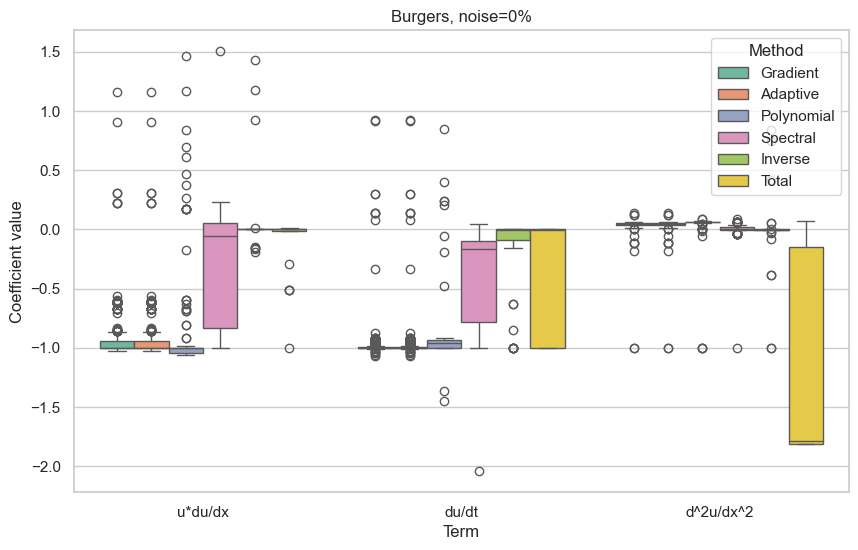

         Term      Method           Mean_CI
0       du/dt    Gradient  -0.9454 ± 0.0301
1       du/dt    Adaptive  -0.9454 ± 0.0301
2       du/dt  Polynomial  -0.9283 ± 0.0332
3       du/dt    Spectral  -0.4025 ± 0.0549
4       du/dt     Inverse  -0.2118 ± 0.1229
5       du/dt       Total  -0.4373 ± 0.2731
6   d^2u/dx^2    Gradient   0.0346 ± 0.0133
7   d^2u/dx^2    Adaptive   0.0346 ± 0.0133
8   d^2u/dx^2  Polynomial   0.0439 ± 0.0188
9   d^2u/dx^2    Spectral   0.0032 ± 0.0171
10  d^2u/dx^2     Inverse  -0.0239 ± 0.1173
11  d^2u/dx^2       Total  -1.2180 ± 0.2525
12    u*du/dx    Gradient  -0.8945 ± 0.0327
13    u*du/dx    Adaptive  -0.8945 ± 0.0327
14    u*du/dx  Polynomial  -0.8931 ± 0.0556
15    u*du/dx    Spectral  -0.3732 ± 0.0849
16    u*du/dx     Inverse   0.0773 ± 0.1174
17    u*du/dx       Total  -0.1324 ± 0.1249


In [5]:
#noise = 0
sns.set(style="whitegrid")

methods = ['Gradient','Adaptive','Polynomial','Spectral','Inverse','Total']
dataframes = []

for method in methods:
    df = pd.read_csv(f'results_Burgers_{method}_cut_noise0.csv')
    df['Method'] = method  # добавляем столбец с методом
    dataframes.append(df)

all_data = pd.concat(dataframes, ignore_index=True)
#переименуем слагаемые
all_data['Term'] = all_data['Term'].replace({ 'du/dx0': "du/dt", 'u * du/dx1 or du/dx1 * u': "u*du/dx", 'd^2u/dx1^2': "d^2u/dx^2" })
#print(all_data)
# Удаляем выбросы
Q1 = all_data['Coefficient'].quantile(0.25)
Q3 = all_data['Coefficient'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = all_data[(all_data['Coefficient'] >= lower_bound) & (all_data['Coefficient'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="Term", y="Coefficient", hue="Method", data=filtered_data, palette="Set2", dodge=True)

plt.title('Burgers, noise=0%')
plt.xlabel('Term')
plt.ylabel('Coefficient value')
plt.legend(title='Method')

plt.savefig('plot_Burgers_noise0.svg', format='svg')
plt.savefig('plot_Burgers_noise0.pdf', format='pdf')
plt.show()

# Определяем список слагаемых и методов
terms = ['du/dt', 'd^2u/dx^2', 'u*du/dx']
methods = ['Gradient', 'Adaptive', 'Polynomial', 'Spectral', 'Inverse', 'Total']

results = []

# Функция для вычисления среднего и доверительного интервала
def compute_mean_and_ci(group):
    mean = group['Coefficient'].mean()
    ci = stats.t.interval(0.95, len(group['Coefficient'])-1, loc=mean, scale=stats.sem(group['Coefficient']))
    return mean, (ci[1] - mean)  # Возвращаем среднее и половину доверительного интервала

# Проходим по каждому слагаемому и методу
for term in terms:
    for method in methods:
        subset = filtered_data[(filtered_data['Term'] == term) & (filtered_data['Method'] == method)]
        
        if not subset.empty:
            mean, margin_of_error = compute_mean_and_ci(subset)
            results.append({'Term': term, 'Method': method, 
                            'Mean_CI': f"{mean:.4f} ± {margin_of_error:.4f}"})

results_df = pd.DataFrame(results)

print(results_df)



In [4]:
filtered_data

,Term,Coefficient,Method
0,u*du/dx',-0.954490,Gradient
1,du/dt,-1.000000,Gradient
2,d^2u/dx^2,0.053507,Gradient
3,u*du/dx',-0.672070,Gradient
4,du/dt,-1.000000,Gradient
...,...,...,...
2754,d^2u/dx^2,-1.786639,Total
2755,u*du/dx',0.000117,Total
2756,du/dt,-0.001496,Total
2757,d^2u/dx^2,-1.000000,Total


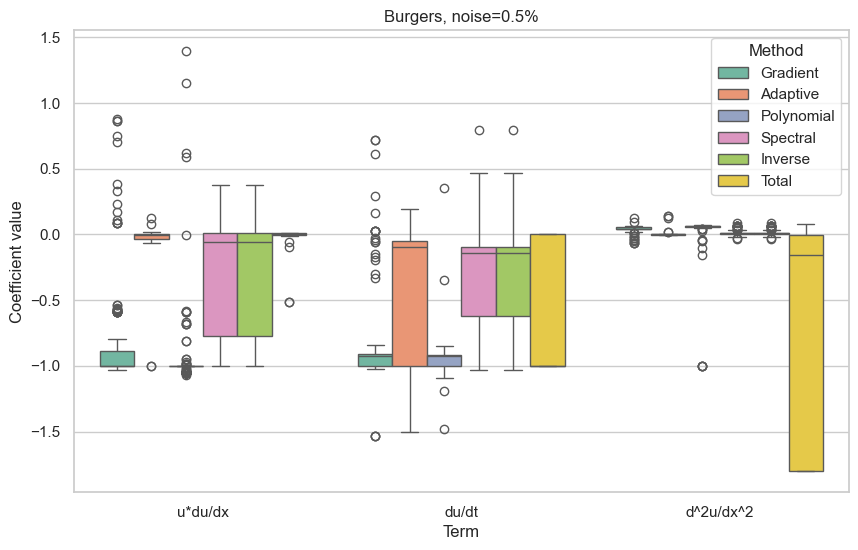

         Term      Method           Mean_CI
0       du/dt    Gradient  -0.8727 ± 0.0398
1       du/dt    Adaptive  -0.3827 ± 0.0621
2       du/dt  Polynomial  -0.9428 ± 0.0150
3       du/dt    Spectral  -0.3064 ± 0.0521
4       du/dt     Inverse  -0.3064 ± 0.0521
5       du/dt       Total  -0.5372 ± 0.3144
6   d^2u/dx^2    Gradient   0.0428 ± 0.0035
7   d^2u/dx^2    Adaptive   0.0081 ± 0.0085
8   d^2u/dx^2  Polynomial   0.0378 ± 0.0202
9   d^2u/dx^2    Spectral   0.0138 ± 0.0033
10  d^2u/dx^2     Inverse   0.0138 ± 0.0033
11  d^2u/dx^2       Total  -0.6960 ± 0.3206
12    u*du/dx    Gradient  -0.8520 ± 0.0479
13    u*du/dx    Adaptive  -0.0278 ± 0.0198
14    u*du/dx  Polynomial  -0.9510 ± 0.0382
15    u*du/dx    Spectral  -0.3226 ± 0.0810
16    u*du/dx     Inverse  -0.3226 ± 0.0810
17    u*du/dx       Total  -0.0470 ± 0.0646


In [3]:
#noise = 0.005
sns.set(style="whitegrid")

methods = ['Gradient','Adaptive','Polynomial','Spectral','Inverse','Total']
dataframes = []

for method in methods:
    df = pd.read_csv(f'results_Burgers_{method}_cut_noise0.005.csv')
    df['Method'] = method  # добавляем столбец с методом
    dataframes.append(df)

all_data = pd.concat(dataframes, ignore_index=True)
all_data['Term'] = all_data['Term'].replace({ 'du/dx0': "du/dt", 'u * du/dx1 or du/dx1 * u': "u*du/dx", 'd^2u/dx1^2': "d^2u/dx^2" })
#print(all_data)
# Удаляем выбросы
Q1 = all_data['Coefficient'].quantile(0.25)
Q3 = all_data['Coefficient'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = all_data[(all_data['Coefficient'] >= lower_bound) & (all_data['Coefficient'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="Term", y="Coefficient", hue="Method", data=filtered_data, palette="Set2", dodge=True)

plt.title('Burgers, noise=0.5%')
plt.xlabel('Term')
plt.ylabel('Coefficient value')
plt.legend(title='Method')
plt.savefig('plot_Burgers_noise0.005.svg', format='svg')
plt.savefig('plot_Burgers_noise0.005.pdf', format='pdf')
plt.show()

terms = ['du/dt', 'd^2u/dx^2', 'u*du/dx']
methods = ['Gradient', 'Adaptive', 'Polynomial', 'Spectral', 'Inverse', 'Total']

results = []

def compute_mean_and_ci(group):
    mean = group['Coefficient'].mean()
    ci = stats.t.interval(0.95, len(group['Coefficient'])-1, loc=mean, scale=stats.sem(group['Coefficient']))
    return mean, (ci[1] - mean)  

for term in terms:
    for method in methods:
        subset = filtered_data[(filtered_data['Term'] == term) & (filtered_data['Method'] == method)]
        
        if not subset.empty:
            mean, margin_of_error = compute_mean_and_ci(subset)
            results.append({'Term': term, 'Method': method, 
                            'Mean_CI': f"{mean:.4f} ± {margin_of_error:.4f}"})

results_df = pd.DataFrame(results)

print(results_df)


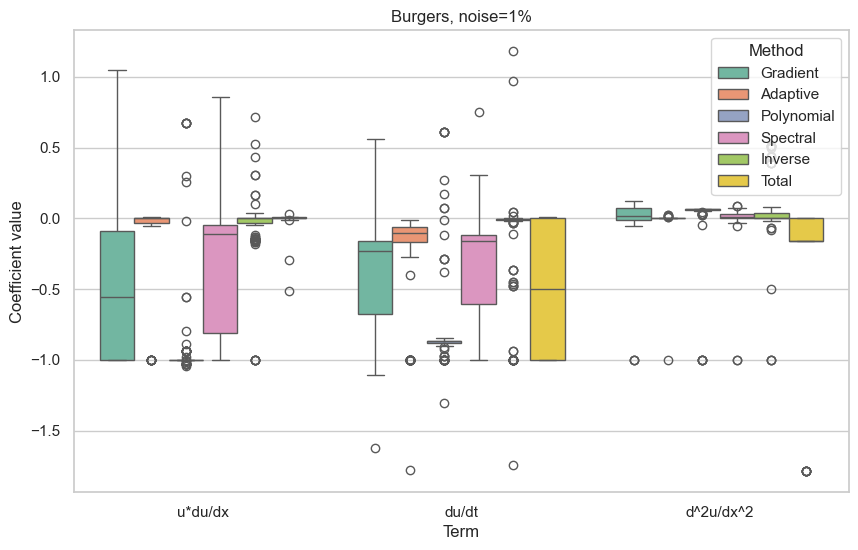

         Term      Method           Mean_CI
0       du/dt    Gradient  -0.4088 ± 0.0448
1       du/dt    Adaptive  -0.2707 ± 0.0511
2       du/dt  Polynomial  -0.8245 ± 0.0360
3       du/dt    Spectral  -0.3414 ± 0.0472
4       du/dt     Inverse  -0.1569 ± 0.0575
5       du/dt       Total  -0.4989 ± 0.1903
6   d^2u/dx^2    Gradient   0.0051 ± 0.0269
7   d^2u/dx^2    Adaptive  -0.0140 ± 0.0313
8   d^2u/dx^2  Polynomial   0.0384 ± 0.0208
9   d^2u/dx^2    Spectral   0.0049 ± 0.0207
10  d^2u/dx^2     Inverse   0.0238 ± 0.0420
11  d^2u/dx^2       Total  -0.3595 ± 0.2082
12    u*du/dx    Gradient  -0.5262 ± 0.0840
13    u*du/dx    Adaptive  -0.0913 ± 0.0478
14    u*du/dx  Polynomial  -0.9395 ± 0.0375
15    u*du/dx    Spectral  -0.3910 ± 0.0798
16    u*du/dx     Inverse  -0.0533 ± 0.0453
17    u*du/dx       Total  -0.0269 ± 0.0465


In [4]:
#noise = 0.01
sns.set(style="whitegrid")

methods = ['Gradient','Adaptive','Polynomial','Spectral','Inverse','Total']
dataframes = []

for method in methods:
    df = pd.read_csv(f'results_Burgers_{method}_cut_noise0.01.csv')
    df['Method'] = method  # добавляем столбец с методом
    dataframes.append(df)

all_data = pd.concat(dataframes, ignore_index=True)
#переименуем слагаемые
all_data['Term'] = all_data['Term'].replace({ 'du/dx0': "du/dt", 'u * du/dx1 or du/dx1 * u': "u*du/dx", 'd^2u/dx1^2': "d^2u/dx^2" })
#print(all_data)
# Удаляем выбросы
Q1 = all_data['Coefficient'].quantile(0.25)
Q3 = all_data['Coefficient'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = all_data[(all_data['Coefficient'] >= lower_bound) & (all_data['Coefficient'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="Term", y="Coefficient", hue="Method", data=filtered_data, palette="Set2", dodge=True)

plt.title('Burgers, noise=1%')
plt.xlabel('Term')
plt.ylabel('Coefficient value')
plt.legend(title='Method')
# Сохраняем график в svg и pdf
plt.savefig('plot_Burgers_noise0.01.svg', format='svg')
plt.savefig('plot_Burgers_noise0.01.pdf', format='pdf')
plt.show()

# Определяем список слагаемых и методов
terms = ['du/dt', 'd^2u/dx^2', 'u*du/dx']
methods = ['Gradient', 'Adaptive', 'Polynomial', 'Spectral', 'Inverse', 'Total']

# Создаем пустой DataFrame для хранения результатов
results = []

# Функция для вычисления среднего и доверительного интервала
def compute_mean_and_ci(group):
    mean = group['Coefficient'].mean()
    ci = stats.t.interval(0.95, len(group['Coefficient'])-1, loc=mean, scale=stats.sem(group['Coefficient']))
    return mean, (ci[1] - mean)  # Возвращаем среднее и половину доверительного интервала

# Проходим по каждому слагаемому и методу
for term in terms:
    for method in methods:
        # Фильтруем данные по текущему слагаемому и методу
        subset = filtered_data[(filtered_data['Term'] == term) & (filtered_data['Method'] == method)]
        
        # Если есть данные, вычисляем среднее и доверительный интервал
        if not subset.empty:
            mean, margin_of_error = compute_mean_and_ci(subset)
            results.append({'Term': term, 'Method': method, 
                            'Mean_CI': f"{mean:.4f} ± {margin_of_error:.4f}"})

# Создаем DataFrame из результатов
results_df = pd.DataFrame(results)

# Выводим результаты
print(results_df)


In [262]:
print(all_data.groupby('Term')['Coefficient'].describe())

                           count      mean       std        min       25%  \
Term                                                                        
d^2u/dx1^2                 718.0 -0.004137  0.238894  -1.787085 -0.000119   
du/dx0                    1094.0 -0.545192  1.524416 -19.347236 -0.870225   
u * du/dx1 or du/dx1 * u   761.0 -0.332016  1.462439  -1.040805 -1.000000   

                               50%       75%        max  
Term                                                     
d^2u/dx1^2                0.016363  0.067298   0.510512  
du/dx0                   -0.195682 -0.076617   9.535502  
u * du/dx1 or du/dx1 * u -0.157553  0.000137  26.311746  


In [272]:
#сравнение того сколько всего уравнений и как часто встречаются нужные слагаемые 
results1 = np.load('results_Burgers_Gradient_noise0.npy')
print('колво уравнений', len(results1))
sns.set(style="whitegrid")

dataframes = []

df = pd.read_csv(f'results_Burgers_Gradient_cut_noise0.csv')
df['Method'] = 'Gradient'  # добавляем столбец с методом
dataframes.append(df)

all_data1 = pd.concat(dataframes, ignore_index=True)
print(all_data1.groupby('Term')['Coefficient'].describe())

колво уравнений 267
                          count      mean       std       min       25%  \
Term                                                                      
d^2u/dx1^2                227.0  0.034647  0.101948 -1.000000  0.037197   
du/dx0                    260.0 -0.919740  0.480861 -1.070265 -1.000000   
u * du/dx1 or du/dx1 * u  262.0 -0.788038  0.812357 -1.023083 -1.000000   

                               50%       75%       max  
Term                                                    
d^2u/dx1^2                0.043882  0.056247  0.136709  
du/dx0                   -1.000000 -0.993315  5.717966  
u * du/dx1 or du/dx1 * u -0.997632 -0.874156  6.419315  


['Gradient'] среднее [4, '±', 0.091]
['Gradient'] [0.0909584614398371]
['Gradient'] [4.090958461439837]
['Gradient'] [3.909041538560163]
['Adaptive'] среднее [4, '±', 0.091]
['Adaptive'] [0.0909584614398371]
['Adaptive'] [4.090958461439837]
['Adaptive'] [3.909041538560163]
['Polynomial'] среднее [4, '±', 0.272]
['Polynomial'] [0.27204043615605933]
['Polynomial'] [4.272040436156059]
['Polynomial'] [3.7279595638439407]
['Spectral'] среднее [6, '±', 0.1993]
['Spectral'] [0.19928600568801258]
['Spectral'] [6.199286005688013]
['Spectral'] [5.800713994311987]
['Inverse'] среднее [6, '±', 0.3554]
['Inverse'] [0.3554320546218035]
['Inverse'] [6.3554320546218035]
['Inverse'] [5.6445679453781965]
['Total'] среднее [6, '±', 0.1299]
['Total'] [0.12992333086046592]
['Total'] [6.129923330860466]
['Total'] [5.870076669139534]


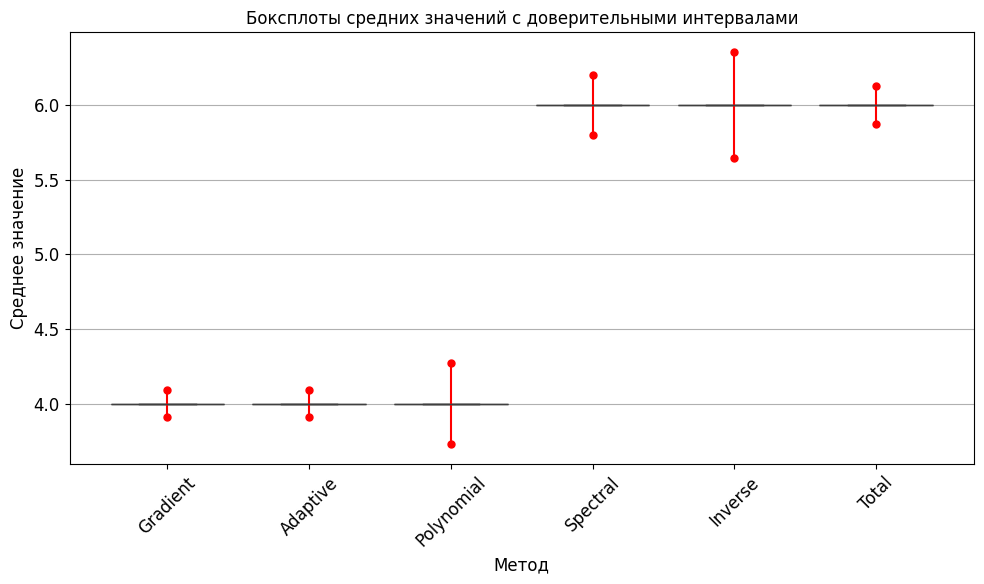

In [34]:
#noise = 0
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data1 = pd.read_csv('Ham_Burgers_Gradient_noise0.csv')
data2 = pd.read_csv('Ham_Burgers_Adaptive_noise0.csv')
data3 = pd.read_csv('Ham_Burgers_Polynomial_noise0.csv')
data4 = pd.read_csv('Ham_Burgers_Spectral_noise0.csv')
data5 = pd.read_csv('Ham_Burgers_Inverse_noise0.csv')
data6= pd.read_csv('Ham_Burgers_Total_noise0.csv')

# Добавление столбца 'Метод' для различия данных
data1['Метод'] = 'Gradient'
data2['Метод'] = 'Adaptive'
data3['Метод'] = 'Polynomial'
data4['Метод'] = 'Spectral'
data5['Метод'] = 'Inverse'
data6['Метод'] = 'Total'

all_data = pd.concat([data1, data2, data3, data4, data5,data6], ignore_index=True)

# Извлечение нижней и верхней границ доверительного интервала
all_data['Доверительный интервал (нижний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[0])
all_data['Доверительный интервал (верхний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[1])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Среднее', data=all_data)

# Добавление доверительных интервалов
for i in range(len(all_data)):
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]],
             color='red', marker='o', markersize=5)
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]],
             color='red', marker='o', markersize=5)

    # Линия между нижним и верхним доверительным интервалом
    plt.plot([all_data['Метод'][i], all_data['Метод'][i]],
             [all_data['Доверительный интервал (нижний)'][i], all_data['Доверительный интервал (верхний)'][i]],
             color='red')
        
    print([all_data['Метод'][i]], 'среднее', [round(all_data['Среднее'][i], 4), "±", round((all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2, 4)])    
    print([all_data['Метод'][i]], [(all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]])

plt.title('Боксплоты средних значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Среднее значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [29]:
print(2,'b',3)

2 b 3


['Gradient'] среднее [5, '±', 0.1412]
['Gradient'] [0.14122478036579267]
['Gradient'] [5.141224780365793]
['Gradient'] [4.858775219634207]
['Adaptive'] среднее [7, '±', 0.2144]
['Adaptive'] [0.21443258438539825]
['Adaptive'] [7.214432584385398]
['Adaptive'] [6.785567415614602]
['Polynomial'] среднее [4, '±', 0.1334]
['Polynomial'] [0.13335276364264192]
['Polynomial'] [4.133352763642642]
['Polynomial'] [3.866647236357358]
['Spectral'] среднее [6, '±', 0.2107]
['Spectral'] [0.21073388547486616]
['Spectral'] [6.210733885474866]
['Spectral'] [5.789266114525134]
['Inverse'] среднее [6, '±', 0.2107]
['Inverse'] [0.21073388547486616]
['Inverse'] [6.210733885474866]
['Inverse'] [5.789266114525134]
['Total'] среднее [6, '±', 0.1152]
['Total'] [0.11521838490276526]
['Total'] [6.115218384902765]
['Total'] [5.884781615097235]


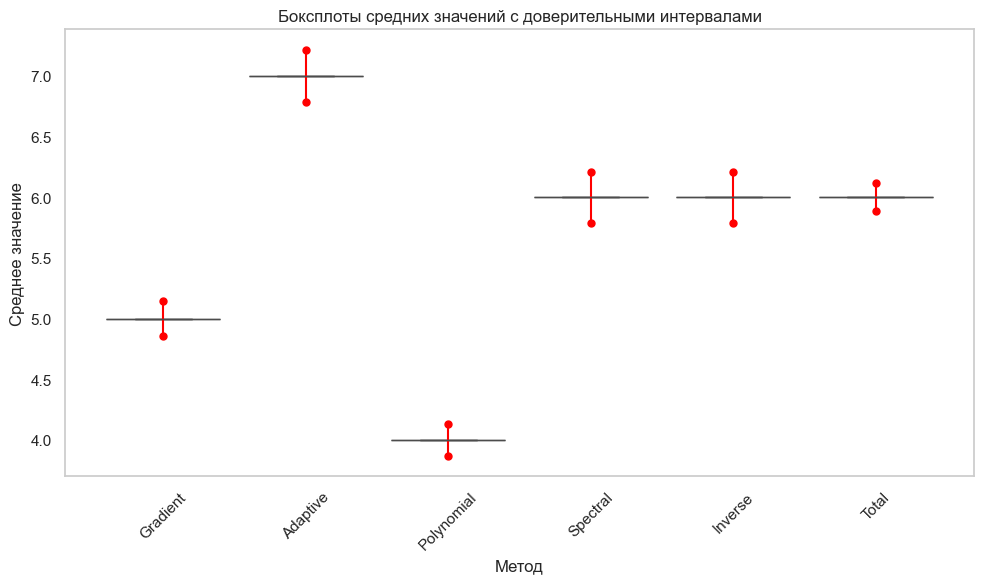

In [5]:
#noise = 0.005
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data1 = pd.read_csv('Ham_Burgers_Gradient_noise0.005.csv')
data2 = pd.read_csv('Ham_Burgers_Adaptive_noise0.005.csv')
data3 = pd.read_csv('Ham_Burgers_Polynomial_noise0.005.csv')
data4 = pd.read_csv('Ham_Burgers_Spectral_noise0.005.csv')
data5 = pd.read_csv('Ham_Burgers_Inverse_noise0.005.csv')
data6 = pd.read_csv('Ham_Burgers_Total_noise0.005.csv')

data1['Метод'] = 'Gradient'
data2['Метод'] = 'Adaptive'
data3['Метод'] = 'Polynomial'
data4['Метод'] = 'Spectral'
data5['Метод'] = 'Inverse'
data6['Метод'] = 'Total'



all_data = pd.concat([data1, data2, data3, data4, data5, data6], ignore_index=True)

# Извлечение нижней и верхней границ доверительного интервала
all_data['Доверительный интервал (нижний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[0])
all_data['Доверительный интервал (верхний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[1])

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Среднее', data=all_data)

# Добавление доверительных интервалов
for i in range(len(all_data)):
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]],
             color='red', marker='o', markersize=5)
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]],
             color='red', marker='o', markersize=5)

    # Линия между нижним и верхним доверительным интервалом
    plt.plot([all_data['Метод'][i], all_data['Метод'][i]],
             [all_data['Доверительный интервал (нижний)'][i], all_data['Доверительный интервал (верхний)'][i]],
             color='red')
    print([all_data['Метод'][i]], 'среднее', [round(all_data['Среднее'][i], 4), "±", round((all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2, 4)])    
    print([all_data['Метод'][i]], [(all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]])
    
plt.title('Боксплоты средних значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Среднее значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


['Gradient'] среднее [6, '±', 0.2134]
['Gradient'] [0.21337047158794498]
['Gradient'] [6.213370471587945]
['Gradient'] [5.786629528412055]
['Adaptive'] среднее [4, '±', 0.127]
['Adaptive'] [0.12698543246442262]
['Adaptive'] [4.126985432464423]
['Adaptive'] [3.8730145675355776]
['Polynomial'] среднее [4, '±', 0.1248]
['Polynomial'] [0.12477461856807359]
['Polynomial'] [4.124774618568074]
['Polynomial'] [3.8752253814319264]
['Spectral'] среднее [6, '±', 0.2096]
['Spectral'] [0.209577837614094]
['Spectral'] [6.209577837614094]
['Spectral'] [5.790422162385906]
['Inverse'] среднее [6, '±', 0.2057]
['Inverse'] [0.20573546629692707]
['Inverse'] [6.205735466296927]
['Inverse'] [5.794264533703073]
['Total'] среднее [6, '±', 0.1283]
['Total'] [0.1283191863983113]
['Total'] [6.128319186398311]
['Total'] [5.871680813601689]


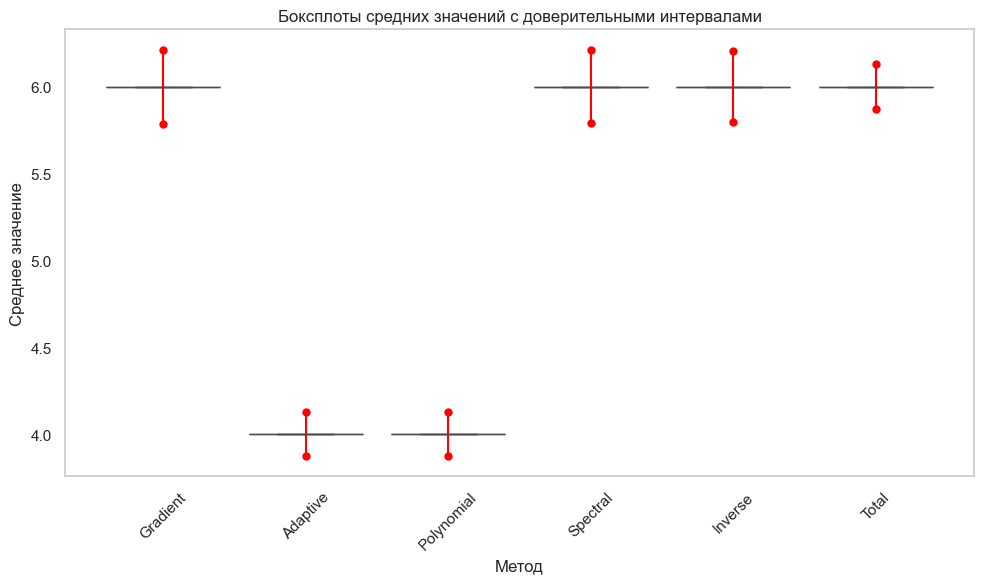

In [6]:
#noise = 0.01
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data1 = pd.read_csv('Ham_Burgers_Gradient_noise0.01.csv')
data2 = pd.read_csv('Ham_Burgers_Adaptive_noise0.01.csv')
data3 = pd.read_csv('Ham_Burgers_Polynomial_noise0.01.csv')
data4 = pd.read_csv('Ham_Burgers_Spectral_noise0.01.csv')
data5 = pd.read_csv('Ham_Burgers_Inverse_noise0.01.csv')
data6 = pd.read_csv('Ham_Burgers_Total_noise0.01.csv')

data1['Метод'] = 'Gradient'
data2['Метод'] = 'Adaptive'
data3['Метод'] = 'Polynomial'
data4['Метод'] = 'Spectral'
data5['Метод'] = 'Inverse'
data6['Метод'] = 'Total'


all_data = pd.concat([data1, data2, data3, data4, data5,data6], ignore_index=True)

# Извлечение нижней и верхней границ доверительного интервала
all_data['Доверительный интервал (нижний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[0])
all_data['Доверительный интервал (верхний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[1])

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Среднее', data=all_data)

# Добавление доверительных интервалов
for i in range(len(all_data)):
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]],
             color='red', marker='o', markersize=5)
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]],
             color='red', marker='o', markersize=5)

    # Линия между нижним и верхним доверительным интервалом
    plt.plot([all_data['Метод'][i], all_data['Метод'][i]],
             [all_data['Доверительный интервал (нижний)'][i], all_data['Доверительный интервал (верхний)'][i]],
             color='red')
    print([all_data['Метод'][i]], 'среднее', [round(all_data['Среднее'][i], 4), "±", round((all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2, 4)])    
    print([all_data['Метод'][i]], [(all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]])
plt.title('Боксплоты средних значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Среднее значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


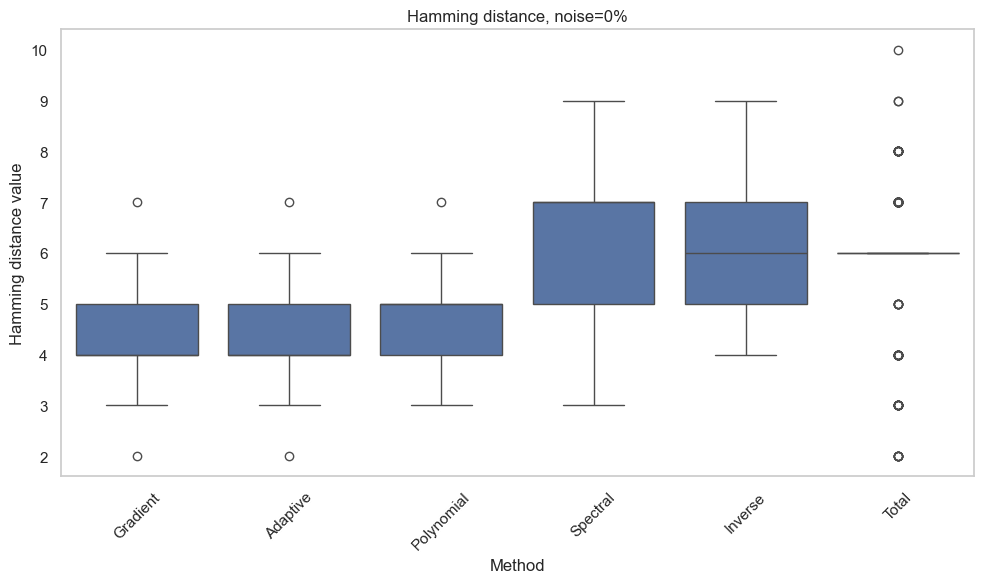

In [13]:
#noise = 0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_gradient = np.load('Hamming_Burgers_Gradient_noise0.npy')
data_adaptive = np.load('Hamming_Burgers_Adaptive_noise0.npy')
data_polynomial = np.load('Hamming_Burgers_Polynomial_noise0.npy')
data_spectral = np.load('Hamming_Burgers_Spectral_noise0.npy')
data_inverse = np.load('Hamming_Burgers_Inverse_noise0.npy')
data_total = np.load('Hamming_Burgers_Total_noise0.npy')

df = pd.DataFrame({
    'Метод': ['Gradient'] * len(data_gradient) + ['Adaptive'] * len(data_adaptive) + ['Polynomial'] * len(data_polynomial) + ['Spectral'] * len(data_spectral) + ['Inverse'] * len(data_inverse) + ['Total'] * len(data_total),
    'Значение': np.concatenate([data_gradient, data_adaptive, data_polynomial, data_spectral, data_inverse, data_total])
})

# Вычисление округленного среднего и доверительных интервалов
summary_df = df.groupby('Метод')['Значение'].agg(['mean', 'std']).reset_index()
summary_df['mean'] = summary_df['mean'].round()  # Округление среднего
confidence_interval = 1.96 * (summary_df['std'] / np.sqrt(df['Метод'].value_counts().values))
summary_df['Доверительный интервал (нижний)'] = summary_df['mean'] - confidence_interval
summary_df['Доверительный интервал (верхний)'] = summary_df['mean'] + confidence_interval

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Значение', data=df)
'''
# Добавление доверительных интервалов на график
for i in range(len(summary_df)):
    plt.plot([i, i], [summary_df['Доверительный интервал (нижний)'][i], summary_df['Доверительный интервал (верхний)'][i]],
             color='red', marker='o')

    # Отметка среднего значения
    plt.plot([i - 0.1, i + 0.1], [summary_df['mean'][i], summary_df['mean'][i]], color='blue', linewidth=2)
'''
plt.title('Hamming distance, noise=0%')
plt.xlabel('Method')
plt.ylabel('Hamming distance value')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Hamming_Burgers_noise0.svg', format='svg')
plt.savefig('Hamming_Burgers_noise0.pdf', format='pdf')
plt.show()


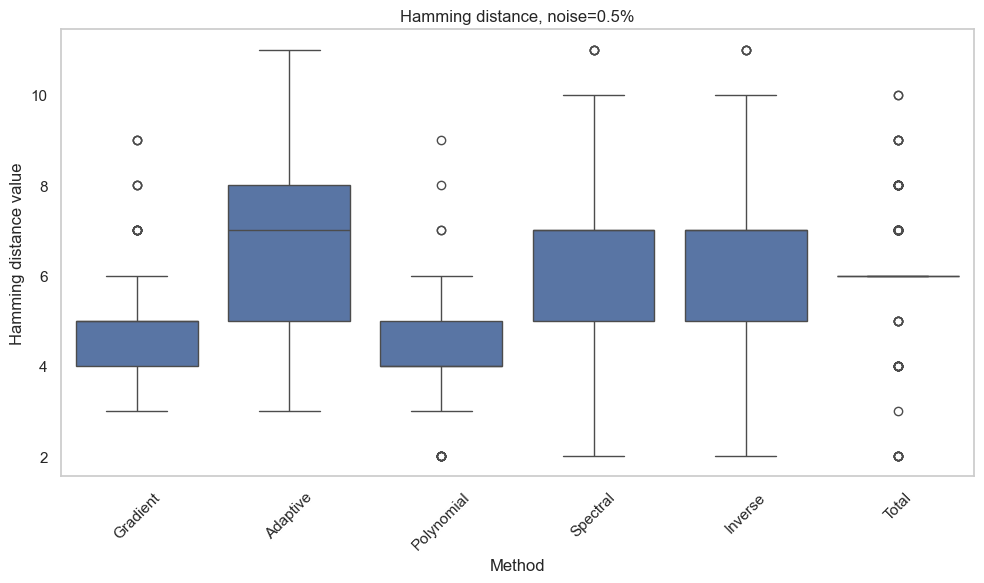

In [14]:
#noise = 0.005
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_gradient = np.load('Hamming_Burgers_Gradient_noise0.005.npy')
data_adaptive = np.load('Hamming_Burgers_Adaptive_noise0.005.npy')
data_polynomial = np.load('Hamming_Burgers_Polynomial_noise0.005.npy')
data_spectral = np.load('Hamming_Burgers_Spectral_noise0.005.npy')
data_inverse = np.load('Hamming_Burgers_Inverse_noise0.005.npy')
data_total = np.load('Hamming_Burgers_Total_noise0.005.npy')

df = pd.DataFrame({
    'Метод': ['Gradient'] * len(data_gradient) + ['Adaptive'] * len(data_adaptive) + ['Polynomial'] * len(data_polynomial) + ['Spectral'] * len(data_spectral) + ['Inverse'] * len(data_inverse) + ['Total'] * len(data_total),
    'Значение': np.concatenate([data_gradient, data_adaptive, data_polynomial, data_spectral, data_inverse, data_total])
})

# Вычисление округленного среднего и доверительных интервалов
summary_df = df.groupby('Метод')['Значение'].agg(['mean', 'std']).reset_index()
summary_df['mean'] = summary_df['mean'].round()  # Округление среднего
confidence_interval = 1.96 * (summary_df['std'] / np.sqrt(df['Метод'].value_counts().values))
summary_df['Доверительный интервал (нижний)'] = summary_df['mean'] - confidence_interval
summary_df['Доверительный интервал (верхний)'] = summary_df['mean'] + confidence_interval

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Значение', data=df)
'''
# Добавление доверительных интервалов на график
for i in range(len(summary_df)):
    plt.plot([i, i], [summary_df['Доверительный интервал (нижний)'][i], summary_df['Доверительный интервал (верхний)'][i]],
             color='red', marker='o')

    # Отметка среднего значения
    plt.plot([i - 0.1, i + 0.1], [summary_df['mean'][i], summary_df['mean'][i]], color='blue', linewidth=2)
'''
plt.title('Hamming distance, noise=0.5%')
plt.xlabel('Method')
plt.ylabel('Hamming distance value')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Hamming_Burgers_noise0.005.svg', format='svg')
plt.savefig('Hamming_Burgers_noise0.005.pdf', format='pdf')
plt.show()


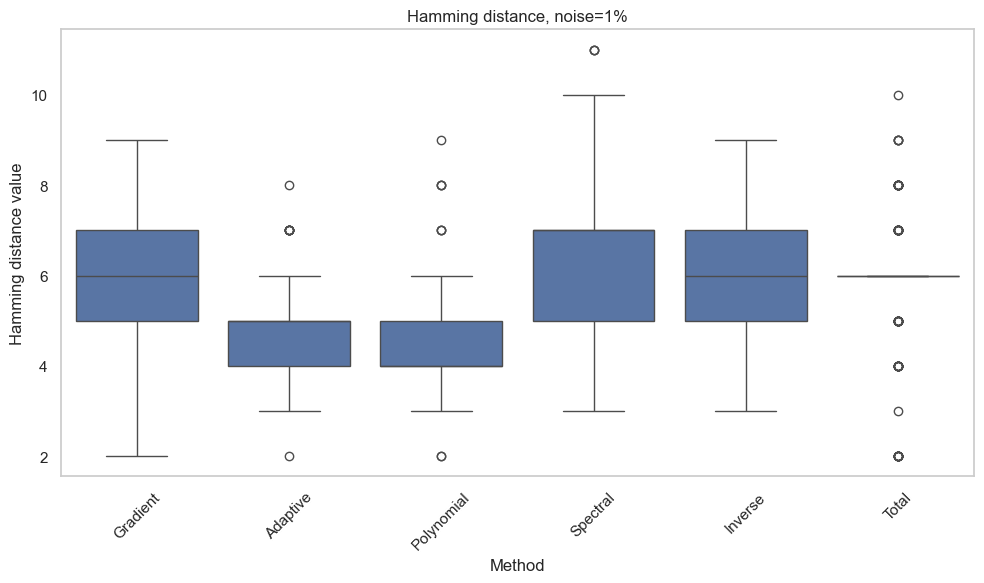

In [15]:
#noise = 0.01
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_gradient = np.load('Hamming_Burgers_Gradient_noise0.01.npy')
data_adaptive = np.load('Hamming_Burgers_Adaptive_noise0.01.npy')
data_polynomial = np.load('Hamming_Burgers_Polynomial_noise0.01.npy')
data_spectral = np.load('Hamming_Burgers_Spectral_noise0.01.npy')
data_inverse = np.load('Hamming_Burgers_Inverse_noise0.01.npy')
data_total = np.load('Hamming_Burgers_Total_noise0.01.npy')


df = pd.DataFrame({
    'Метод': ['Gradient'] * len(data_gradient) + ['Adaptive'] * len(data_adaptive) + ['Polynomial'] * len(data_polynomial) + ['Spectral'] * len(data_spectral) + ['Inverse'] * len(data_inverse) + ['Total'] * len(data_total),
    'Значение': np.concatenate([data_gradient, data_adaptive, data_polynomial, data_spectral, data_inverse, data_total])
})

# Вычисление округленного среднего и доверительных интервалов
summary_df = df.groupby('Метод')['Значение'].agg(['mean', 'std']).reset_index()
summary_df['mean'] = summary_df['mean'].round()  # Округление среднего
confidence_interval = 1.96 * (summary_df['std'] / np.sqrt(df['Метод'].value_counts().values))
summary_df['Доверительный интервал (нижний)'] = summary_df['mean'] - confidence_interval
summary_df['Доверительный интервал (верхний)'] = summary_df['mean'] + confidence_interval

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Значение', data=df)
'''
# Добавление доверительных интервалов на график
for i in range(len(summary_df)):
    plt.plot([i, i], [summary_df['Доверительный интервал (нижний)'][i], summary_df['Доверительный интервал (верхний)'][i]],
             color='red', marker='o')

    # Отметка среднего значения
    plt.plot([i - 0.1, i + 0.1], [summary_df['mean'][i], summary_df['mean'][i]], color='blue', linewidth=2)
'''
plt.title('Hamming distance, noise=1%')
plt.xlabel('Method')
plt.ylabel('Hamming distance value')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Hamming_Burgers_noise0.01.svg', format='svg')
plt.savefig('Hamming_Burgers_noise0.01.pdf', format='pdf')
plt.show()


    day  total_bill smoker
0   Sat   11.571459    Yes
1   Sun   41.820521     No
2  Thur   25.717799     No
3   Sat   35.428535     No
4   Sat   55.378324    Yes


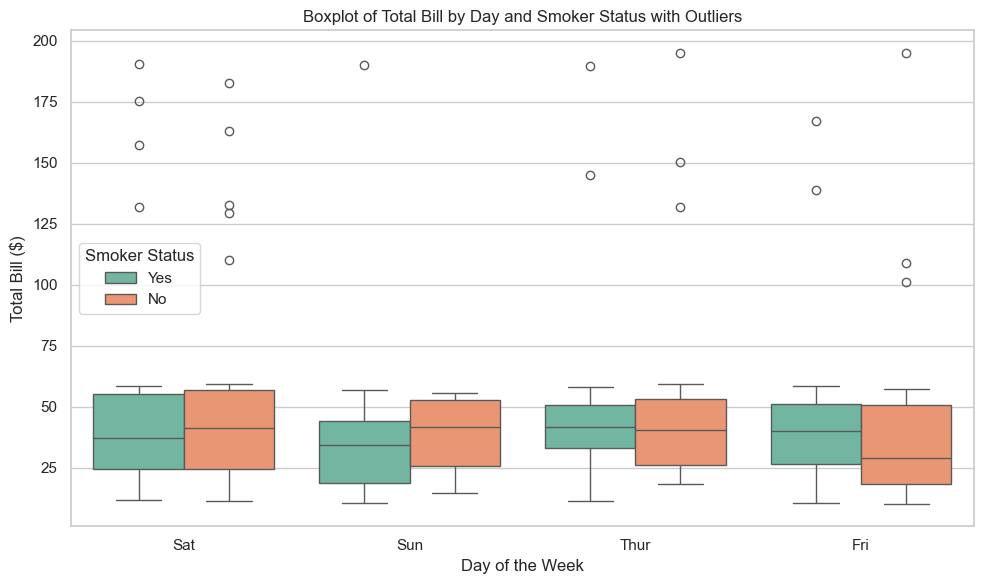

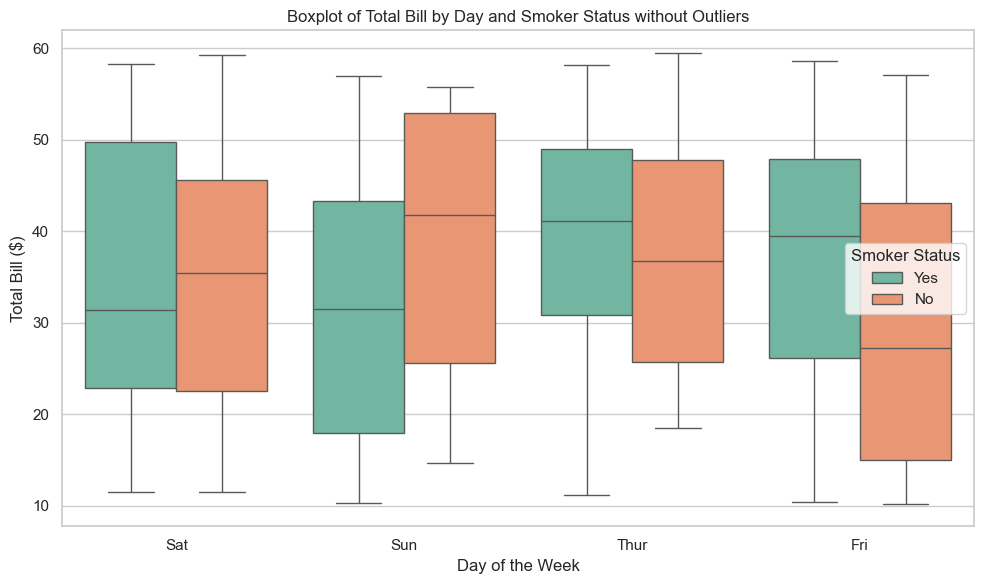

In [436]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Установка стиля графиков
sns.set(style="whitegrid")

# Установка случайного сид для воспроизводимости
np.random.seed(42)

# Создание рандомного датафрейма
days = ['Thur', 'Fri', 'Sat', 'Sun']
smoker_status = ['Yes', 'No']

# Генерация данных
data = {
    'day': np.random.choice(days, size=200),  # Случайные дни
    'total_bill': np.random.uniform(10, 60, size=200),  # Случайные суммы счетов от 10 до 60
    'smoker': np.random.choice(smoker_status, size=200)  # Случайный статус курильщика
}

# Создание DataFrame
tips = pd.DataFrame(data)

# Добавление выбросов
n_outliers = 20  # Количество выбросов
outliers = np.random.uniform(100, 200, size=n_outliers)  # Выбросы от 100 до 200

# Создание датафрейма с выбросами
outlier_data = pd.DataFrame({
    'day': np.random.choice(days, size=n_outliers),
    'total_bill': outliers,
    'smoker': np.random.choice(smoker_status, size=n_outliers)
})

# Объединение основного датафрейма с выбросами
tips = pd.concat([tips, outlier_data], ignore_index=True)

# Вывод первых нескольких строк датафрейма
print(tips.head())

# Построение боксплота с выбросами
plt.figure(figsize=(10, 6))
sns.boxplot(x="day", y="total_bill", hue="smoker", data=tips, palette="Set2", dodge=True)

# Настройка графика
plt.title('Boxplot of Total Bill by Day and Smoker Status with Outliers')
plt.xlabel('Day of the Week')
plt.ylabel('Total Bill ($)')
plt.legend(title='Smoker Status')
plt.tight_layout()

# Показываем график
plt.show()

# Удаление выбросов с использованием метода IQR
Q1 = tips['total_bill'].quantile(0.25)
Q3 = tips['total_bill'].quantile(0.75)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
filtered_tips = tips[(tips['total_bill'] >= lower_bound) & (tips['total_bill'] <= upper_bound)]

# Построение боксплота без выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(x="day", y="total_bill", hue="smoker", data=filtered_tips, palette="Set2", dodge=True)

# Настройка графика
plt.title('Boxplot of Total Bill by Day and Smoker Status without Outliers')
plt.xlabel('Day of the Week')
plt.ylabel('Total Bill ($)')
plt.legend(title='Smoker Status')
plt.tight_layout()

# Показываем график
plt.show()


In [470]:
print(tips.groupby('day')['total_bill'].describe())

      count       mean        std        min        25%        50%        75%  \
day                                                                             
Fri    67.0  45.887394  34.498418  12.053376  25.419429  37.914673  52.378540   
Sat    77.0  39.348513  30.334871  10.259243  22.810347  31.923706  45.445550   
Thur   76.0  50.983419  43.802196  11.380839  23.718040  37.384005  55.945725   

             max  
day               
Fri   189.189691  
Sat   186.313852  
Thur  190.769371  
